# Python Statistics Essential Training

## Linear Regression


### 03_01 - Linear Regression

Goals:

* Understand how to prepare data for linear regression by selecting the relevant numerical features and the target variable.
* Learn to split the data into training and testing sets using `train_test_split` 
* Evaluate the performance of the linear regression model 

In [4]:
import pandas as pd
url = 'https://github.com/mattharrison/datasets/raw/master/data/ames-housing-dataset.zip'
raw = pd.read_csv(url, engine='pyarrow', dtype_backend='pyarrow')

# Define a function to shrink integer columns to smaller unsigned types if possible
def shrink_ints(df):
    mapping = {}                                                # Initialize a dictionary to store column name and target type mappings
    for col in df.dtypes[df.dtypes == 'int64[pyarrow]'].index:  # Iterate over columns of type 'int64[pyarrow]'
        max_ = df[col].max()                                    # Find the maximum value in the column
        min_ = df[col].min()                                    # Find the minimum value in the column
        if min_ < 0:                                            # Skip columns with negative values (unsigned types can't represent negatives)
            continue
        if max_ < 255:                                          # If the maximum value fits in a uint8 (0-255), map to 'uint8[pyarrow]'
            mapping[col] = 'uint8[pyarrow]'
        elif max_ < 65_535:                                     # If the maximum value fits in a uint16 (0-65,534), map to 'uint16[pyarrow]'
            mapping[col] = 'uint16[pyarrow]'
        elif max_ < 4_294_967_295:                              # If the maximum value fits in a uint32 (0-4,294,967,294), map to 'uint32[pyarrow]'
            mapping[col] = 'uint32[pyarrow]'
    return df.astype(mapping)                                   # Convert the DataFrame to the new types according to the mapping

# Define a function to clean the housing data, including handling missing values
def clean_housing_no_na(df):
    return (df
     .assign(**df.select_dtypes('string').replace('', 'Missing').astype('category'),  # Replace empty strings with 'Missing' and convert to categorical
             **{'Garage Yr Blt': df['Garage Yr Blt'].clip(upper=df['Year Built'].max())})  # Clip 'Garage Yr Blt' at the maximum 'Year Built' value
     .pipe(shrink_ints)                                                          # Apply the shrink_ints function to reduce the size of integer columns
     .pipe(lambda df_: df_.assign(**df_.select_dtypes('number').fillna(0)))      # Fill NaN values in numeric columns with 0 <========================
    )    

# Apply the cleaning function to the raw housing data
housing2 = clean_housing_no_na(raw)

In [5]:
from sklearn import linear_model, model_selection, preprocessing

X = housing2.select_dtypes('number').drop(columns='SalePrice')  # Select numeric columns from housing, excluding 'SalePrice' as features
y = housing2['SalePrice']                                       # Set 'SalePrice' as the target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42)  
# Split data with 75% for training and 25% for testing, using a fixed random state for reproducibility

In [6]:
X_train

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold
844,845,907181100,20,68,9017,7,5,1999,1999,0,...,666,0,35,0,0,0,0,0,9,2009
2730,2731,905351045,150,0,1700,7,5,1980,1981,0,...,450,188,36,0,0,200,0,0,4,2006
2793,2794,907255050,20,0,14781,8,5,2001,2002,178,...,748,198,150,0,0,0,0,0,8,2006
1187,1188,534127230,20,85,11050,6,5,1968,1968,0,...,512,25,0,0,0,192,0,0,10,2008
2770,2771,907130110,60,65,12438,6,5,1995,1995,68,...,473,413,91,0,0,0,0,0,8,2006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,1639,527226040,190,195,41600,5,5,1969,1990,0,...,828,144,0,0,0,0,0,0,11,2007
1095,1096,528290090,60,0,7750,7,5,2002,2002,0,...,403,100,35,0,0,0,0,0,4,2008
1130,1131,528490080,60,64,8791,6,5,2003,2003,0,...,673,216,56,0,0,0,0,0,5,2008
1294,1295,902109160,50,81,7308,5,5,1920,1950,0,...,225,0,0,236,0,0,0,0,6,2008


In [7]:
y_train

844     192000
2730    148400
2793    275000
1187    150000
2770    187000
         ...  
1638    155000
1095    176000
1130    207500
1294    122250
860     133900
Name: SalePrice, Length: 2197, dtype: uint32[pyarrow]

In [8]:
lr = linear_model.LinearRegression()  # Initialize a linear regression model
lr.fit(X_train, y_train)              # Fit the linear regression model to the training data
lr.score(X_test, y_test)              # Evaluate the model on the test data and return the coefficient of determination (R^2)

0.8434707037243754

### 03_02 - Interpreting Linear Regression Models

In [10]:
# Access the coefficients
coefficients = lr.coef_
print(coefficients)

[-1.03814738e+01  9.02411860e-07 -1.63050576e+02  2.81284818e+01
  4.92668567e-01  1.73466716e+04  4.84079679e+03  3.91645014e+02
  1.76965630e+02  2.73066661e+01  1.05967268e+01  4.13482954e+00
 -2.72937999e+00  1.20021763e+01  1.87157914e+01  2.54896651e+01
 -9.18032347e+00  3.50251329e+01  7.35666770e+03 -1.51315712e+03
 -1.41742224e+02 -5.39960782e+03 -7.73039749e+03 -1.43271176e+04
  1.36191997e+03  3.51407523e+03 -1.31044446e+01  1.03630326e+04
  1.49225509e+01  1.99789208e+01 -6.04065085e+00  2.04208107e+01
 -5.67776073e+00  7.08392922e+01 -3.93865793e+01 -8.71867696e+00
  2.35118730e+02 -8.15826993e+03]


In [11]:
# Access the intercept
intercept = lr.intercept_
print(intercept)

15240773.746056011


In [12]:
# Access the feature names
feature_names = lr.feature_names_in_
print(feature_names)

['Order' 'PID' 'MS SubClass' 'Lot Frontage' 'Lot Area' 'Overall Qual'
 'Overall Cond' 'Year Built' 'Year Remod/Add' 'Mas Vnr Area'
 'BsmtFin SF 1' 'BsmtFin SF 2' 'Bsmt Unf SF' 'Total Bsmt SF' '1st Flr SF'
 '2nd Flr SF' 'Low Qual Fin SF' 'Gr Liv Area' 'Bsmt Full Bath'
 'Bsmt Half Bath' 'Full Bath' 'Half Bath' 'Bedroom AbvGr' 'Kitchen AbvGr'
 'TotRms AbvGrd' 'Fireplaces' 'Garage Yr Blt' 'Garage Cars' 'Garage Area'
 'Wood Deck SF' 'Open Porch SF' 'Enclosed Porch' '3Ssn Porch'
 'Screen Porch' 'Pool Area' 'Misc Val' 'Mo Sold' 'Yr Sold']


In [13]:
# Create a pandas Series that maps feature names to their corresponding coefficients
coefficients_series = pd.Series(lr.coef_, index=lr.feature_names_in_)
print(coefficients_series)

Order             -1.038147e+01
PID                9.024119e-07
MS SubClass       -1.630506e+02
Lot Frontage       2.812848e+01
Lot Area           4.926686e-01
Overall Qual       1.734667e+04
Overall Cond       4.840797e+03
Year Built         3.916450e+02
Year Remod/Add     1.769656e+02
Mas Vnr Area       2.730667e+01
BsmtFin SF 1       1.059673e+01
BsmtFin SF 2       4.134830e+00
Bsmt Unf SF       -2.729380e+00
Total Bsmt SF      1.200218e+01
1st Flr SF         1.871579e+01
2nd Flr SF         2.548967e+01
Low Qual Fin SF   -9.180323e+00
Gr Liv Area        3.502513e+01
Bsmt Full Bath     7.356668e+03
Bsmt Half Bath    -1.513157e+03
Full Bath         -1.417422e+02
Half Bath         -5.399608e+03
Bedroom AbvGr     -7.730397e+03
Kitchen AbvGr     -1.432712e+04
TotRms AbvGrd      1.361920e+03
Fireplaces         3.514075e+03
Garage Yr Blt     -1.310444e+01
Garage Cars        1.036303e+04
Garage Area        1.492255e+01
Wood Deck SF       1.997892e+01
Open Porch SF     -6.040651e+00
Enclosed

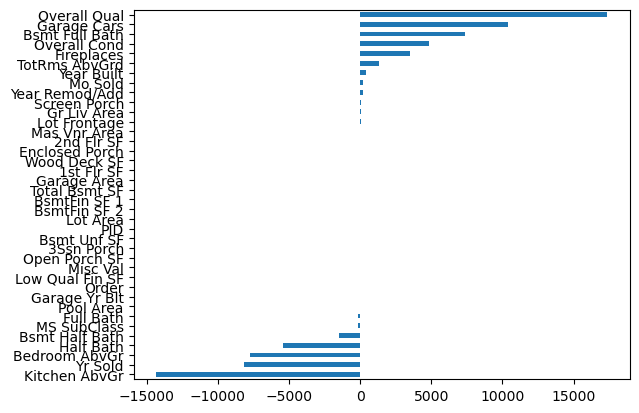

In [14]:
# Create a pandas Series that maps feature names to their corresponding coefficients, sort them, and plot as a horizontal bar chart
(pd.Series(lr.coef_, index=lr.feature_names_in_)  # Create a Series mapping feature names to coefficients
 .sort_values()                                   # Sort the coefficients in ascending order
 .plot.barh());                                   # Plot the sorted coefficients as a horizontal bar chart

The weights that impact the model the most. In this case, it is saying overall quality pushes the model towards a more positive price, and kitchen above ground pushes the model towards a more negative price, as that increases. You can see in the middle here, there are a bunch of the features or columns that have a small value. These columns are features that don't have a large impact on the output of the model. 

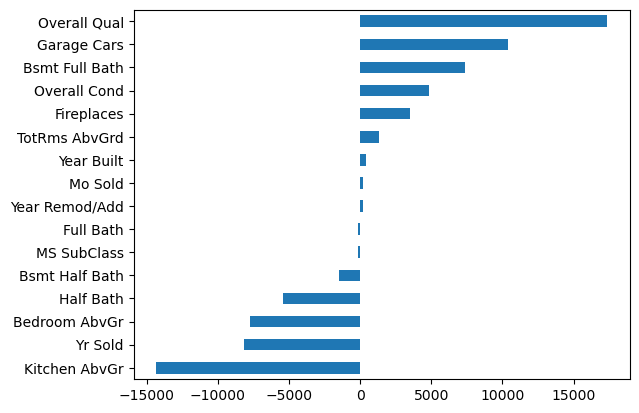

In [16]:
# Create a pandas Series mapping feature names to their corresponding coefficients,
# filter out coefficients with an absolute value greater than 100, sort them, and plot as a horizontal bar chart

(pd.Series(lr.coef_, index=lr.feature_names_in_)  # Create a Series mapping feature names to coefficients
 .pipe(lambda ser: ser[ser.abs() > 100])          # Filter the Series to keep only coefficients with an absolute value greater than 100
 .sort_values()                                   # Sort the filtered coefficients in ascending order
 .plot.barh());                                   # Plot the sorted coefficients as a horizontal bar chart

In [17]:
# Create a pandas Series mapping feature names to their corresponding coefficients,
# filter out coefficients with an absolute value greater than 100, sort them, and return the index (feature names)

significant_features = (pd.Series(lr.coef_, index=lr.feature_names_in_)  # Create a Series mapping feature names to coefficients
 .pipe(lambda ser: ser[ser.abs() > 100])          # Filter the Series to keep only coefficients with an absolute value greater than 100
 .sort_values()                                   # Sort the filtered coefficients in ascending order
 .index)                                          # Return the index (feature names) of the sorted Series
print(significant_features)

Index(['Kitchen AbvGr', 'Yr Sold', 'Bedroom AbvGr', 'Half Bath',
       'Bsmt Half Bath', 'MS SubClass', 'Full Bath', 'Year Remod/Add',
       'Mo Sold', 'Year Built', 'TotRms AbvGrd', 'Fireplaces', 'Overall Cond',
       'Bsmt Full Bath', 'Garage Cars', 'Overall Qual'],
      dtype='object')


### 03_03 - Standardizing Values

Goals:

* Understand the concept of standardization 
* Learn to use the `StandardScaler` class 
* Evaluate the impact of standardization on the performance of the linear regression model using the coefficient of determination (R-squared) score.
* Visualize the coefficients of the linear regression model using a horizontal bar plot.

In [19]:
# Select numeric columns from housing2, excluding 'SalePrice', as features
X = housing2.select_dtypes('number').drop(columns='SalePrice')  # Create the feature matrix by selecting numeric columns and excluding 'SalePrice'
y = housing2['SalePrice']                                       # Set 'SalePrice' as the target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42)

# Initialize a StandardScaler for feature scaling (mean=0, variance=1)
std = preprocessing.StandardScaler() 

# Fit the scaler on the training data and transform it
X_train = std.fit_transform(X_train)

# Apply the same transformation to the test data
X_test = std.transform(X_test)

In [20]:
# Initialize and train the linear regression model
lr = linear_model.LinearRegression()  # Initialize the linear regression model
lr.fit(X_train, y_train)              # Fit the model to the standardized training data

# Evaluate the model on the test data
score = lr.score(X_test, y_test)  # Calculate the R^2 score of the model on the test data
print(score)                      # Output the R^2 score

0.8434693194686513


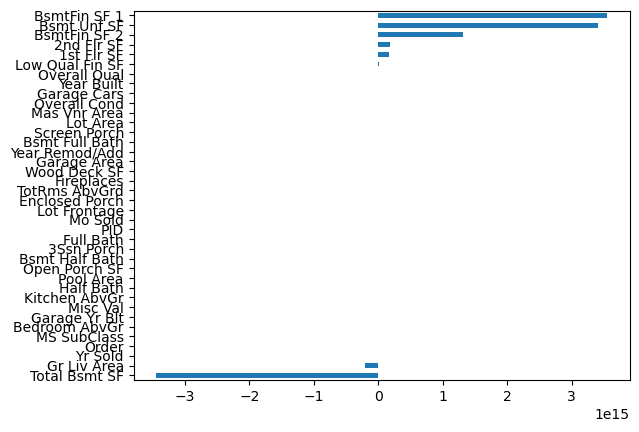

In [21]:
# Create a pandas Series that maps feature names to their corresponding coefficients,
# sort the coefficients, and plot them as a horizontal bar chart

(pd.Series(lr.coef_, index=X.columns)  # Create a Series mapping feature names (from X.columns) to their corresponding coefficients (from lr.coef_)
 .sort_values()                        # Sort the coefficients in ascending order for easier interpretation
 .plot.barh());                        # Plot the sorted coefficients as a horizontal bar chart

In [22]:
# Create a pandas Series that maps feature names to their corresponding coefficients,
# sort the coefficients, and (optionally) plot them as a horizontal bar chart

coefficients_series = (pd.Series(lr.coef_, index=X.columns)  # Create a Series mapping feature names to their corresponding coefficients
 .sort_values()                                              # Sort the coefficients in ascending order for easier interpretation
# .plot.barh()                                               # (Optional) Plot the sorted coefficients as a horizontal bar chart
)

coefficients_series  # Display the sorted Series of coefficients

Total Bsmt SF     -3.446970e+15
Gr Liv Area       -2.110392e+14
Yr Sold           -1.072459e+04
Order             -8.755962e+03
MS SubClass       -6.993341e+03
Bedroom AbvGr     -6.364515e+03
Garage Yr Blt     -5.755203e+03
Misc Val          -5.578304e+03
Kitchen AbvGr     -3.052038e+03
Half Bath         -2.705048e+03
Pool Area         -1.449753e+03
Open Porch SF     -4.146587e+02
Bsmt Half Bath    -3.629343e+02
3Ssn Porch        -1.422653e+02
Full Bath         -7.640614e+01
PID                1.687345e+02
Mo Sold            6.354114e+02
Lot Frontage       9.472846e+02
Enclosed Porch     1.356599e+03
TotRms AbvGrd      2.147308e+03
Fireplaces         2.301076e+03
Wood Deck SF       2.505710e+03
Garage Area        3.171714e+03
Year Remod/Add     3.672956e+03
Bsmt Full Bath     3.873249e+03
Screen Porch       3.998432e+03
Lot Area           4.059535e+03
Mas Vnr Area       4.746076e+03
Overall Cond       5.372853e+03
Garage Cars        7.756241e+03
Year Built         1.188778e+04
Overall 

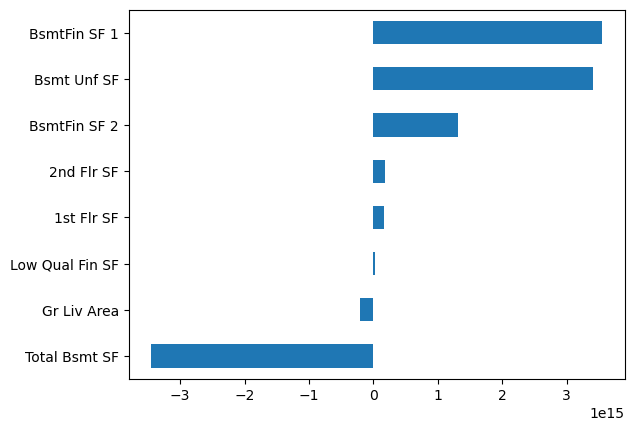

In [23]:
# Create a pandas Series that maps feature names to their corresponding coefficients,
# filter out coefficients with an absolute value greater than 1e8, sort them, and plot as a horizontal bar chart

(pd.Series(lr.coef_, index=X.columns)     # Create a Series mapping feature names (from X.columns) to their corresponding coefficients (from lr.coef_)
 .sort_values()                           # Sort the coefficients in ascending order for easier interpretation
 .pipe(lambda ser: ser[ser.abs() > 1e8])  # Filter the Series to keep only coefficients with an absolute value greater than 1e8
 .plot.barh()                             # Plot the filtered and sorted coefficients as a horizontal bar chart
);

In [24]:
# Define two sets of features: simple_feats and std_feats
simple_feats = set(['Kitchen AbvGr', 'Yr Sold', 'Bedroom AbvGr', 'Half Bath',  # Set of 'simple' features related to counts and years
       'Bsmt Half Bath', 'MS SubClass', 'Full Bath', 'Year Remod/Add',
       'Mo Sold', 'Year Built', 'TotRms AbvGrd', 'Fireplaces', 'Overall Cond',
       'Bsmt Full Bath', 'Garage Cars', 'Overall Qual'])

std_feats = set(['Total Bsmt SF', '2nd Flr SF', '1st Flr SF', 'Low Qual Fin SF',  # Set of 'standardized' features related to square footage and areas
       'BsmtFin SF 2', 'Gr Liv Area', 'Bsmt Unf SF', 'BsmtFin SF 1'])

# Combine the two sets and sort the combined list of feature names
print(sorted(simple_feats | std_feats))  # Use the union operator '|' to combine the two sets and sort the resulting set alphabetically

['1st Flr SF', '2nd Flr SF', 'Bedroom AbvGr', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Fireplaces', 'Full Bath', 'Garage Cars', 'Gr Liv Area', 'Half Bath', 'Kitchen AbvGr', 'Low Qual Fin SF', 'MS SubClass', 'Mo Sold', 'Overall Cond', 'Overall Qual', 'TotRms AbvGrd', 'Total Bsmt SF', 'Year Built', 'Year Remod/Add', 'Yr Sold']


In [25]:
# Look at correlations between selected features and SalePrice
(X
 .assign(SalePrice=y)   # Add the SalePrice column to the feature matrix X
 .corr()                # Compute the correlation matrix for all numeric features including SalePrice
 .loc[['SalePrice', '1st Flr SF', '2nd Flr SF', 'Bedroom AbvGr', 'Bsmt Full Bath', 'Bsmt Half Bath', 
       'Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Fireplaces', 'Full Bath', 
       'Garage Cars', 'Gr Liv Area', 'Half Bath', 'Kitchen AbvGr', 'Low Qual Fin SF',
       'MS SubClass', 'Mo Sold', 'Overall Cond', 'Overall Qual', 'TotRms AbvGrd', 
       'Total Bsmt SF', 'Year Built', 'Year Remod/Add', 'Yr Sold']]  # Select specific rows from the correlation matrix
 .style                                                              # Apply styling to the DataFrame for better visualization
 .background_gradient(cmap='RdBu', vmin=-1, vmax=1)                  # Apply a background gradient with the 'RdBu' colormap, ranging from -1 to 1
 .set_sticky(axis='index')                                           # Make the index (row labels) sticky when scrolling
)

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
SalePrice,-0.031408,-0.246521,-0.085092,0.201875,0.266549,0.799262,-0.101697,0.558426,0.532974,0.502196,0.433147,0.006018,0.183308,0.632529,0.621676,0.269373,-0.037660,0.706780,0.275823,-0.035817,0.545604,0.285056,0.143913,-0.119814,0.495474,0.474558,0.253317,0.647562,0.640138,0.327143,0.312951,-0.128787,0.032225,0.112151,0.068403,-0.015691,0.035259,-0.030569,1.000000
1st Flr SF,-0.013201,-0.141902,-0.247828,0.241707,0.332235,0.477837,-0.157052,0.310463,0.242108,0.392280,0.457586,0.084710,0.296139,0.800429,1.000000,-0.250057,-0.012689,0.562166,0.257836,0.010469,0.371584,-0.104203,0.106648,0.076025,0.390162,0.406345,0.147876,0.439471,0.491208,0.227131,0.238041,-0.065713,0.044061,0.098316,0.121821,0.093003,0.040496,-0.013667,0.621676
2nd Flr SF,-0.000417,-0.003289,0.304237,-0.002813,0.032996,0.241402,0.006218,0.016828,0.158939,0.120159,-0.163710,-0.098188,0.002320,-0.204487,-0.250057,1.000000,0.018024,0.655251,-0.163068,-0.059458,0.404143,0.611634,0.504651,0.069444,0.585214,0.165844,0.041983,0.180882,0.127508,0.089097,0.184538,0.055429,-0.032172,0.011741,0.044602,-0.005078,0.013247,-0.018530,0.269373
Bedroom AbvGr,0.015424,0.006345,-0.019208,0.112718,0.136569,0.063291,-0.006137,-0.055093,-0.021536,0.080590,-0.118575,-0.033033,0.188508,0.052721,0.106648,0.504651,0.070531,0.516808,-0.161084,0.020333,0.359489,0.247053,1.000000,0.240737,0.672647,0.076971,-0.038905,0.091135,0.073417,0.029711,0.083650,0.052115,-0.047151,0.009250,0.036707,0.000887,0.053677,-0.018008,0.143913
Bsmt Full Bath,-0.042499,-0.038306,0.014187,0.019554,0.124208,0.168373,-0.043458,0.212119,0.134590,0.139684,0.640212,0.163634,-0.398629,0.326861,0.257836,-0.163068,-0.047215,0.057367,1.000000,-0.149027,-0.023011,-0.035385,-0.161084,-0.018349,-0.043642,0.172775,0.064179,0.162644,0.184903,0.187283,0.080765,-0.069014,0.027086,0.052355,0.043730,-0.004817,-0.003322,0.044805,0.275823
Bsmt Half Bath,0.024987,0.004154,-0.003179,-0.031798,0.026448,-0.041433,0.084185,-0.030515,-0.046175,0.016609,0.077687,0.099147,-0.105784,0.012850,0.010469,-0.059458,-0.013385,-0.043498,-0.149027,1.000000,-0.046371,-0.057999,0.020333,-0.064671,-0.048069,0.038089,0.001307,-0.033210,-0.021147,0.051546,-0.035276,-0.009272,0.026971,0.042372,0.066911,0.036996,0.022741,-0.019556,-0.035817
Bsmt Unf SF,0.005842,-0.088102,-0.129987,0.139290,0.023883,0.270527,-0.137303,0.129311,0.165397,0.089662,-0.477244,-0.238420,1.000000,0.412248,0.296139,0.002320,0.047207,0.235870,-0.398629,-0.105784,0.274901,-0.033530,0.188508,0.065651,0.251633,0.001790,0.013214,0.180080,0.164837,-0.039285,0.119143,0.006383,-0.005399,-0.047945,-0.031963,-0.010125,0.021915,-0.036443,0.183308
BsmtFin SF 1,-0.032268,-0.098674,-0.059767,0.067034,0.191692,0.284458,-0.051341,0.280069,0.152240,0.299951,1.000000,-0.054022,-0.477244,0.536731,0.457586,-0.163710,-0.066129,0.209944,0.640212,0.077687,0.078086,-0.008205,-0.118575,-0.086654,0.048118,0.296098,0.125795,0.255311,0.309649,0.224199,0.125150,-0.100318,0.050567,0.095952,0.084147,0.092900,-0.000884,0.022341,0.433147
BsmtFin SF 2,-0.002758,-0.001245,-0.070847,-0.005254,0.083198,-0.041122,0.040992,-0.027328,-0.061934,-0.014955,-0.054022,1.000000,-0.238420,0.090109,0.084710,-0.098188,-0.004989,-0.017996,0.163634,0.099147,-0.076262,-0.033004,-0.033033,-0.037864,-0.049288,0.067180,0.048897,-0.014118,0.003625,0.098591,-0.005516,0.032415,-0.023314,0.062978,0.044403,-0.005195,-0.009401,0.007089,0.006018
Fireplaces,-0.019156,-0.108056,-0.049955,0.051240,0.256989,0.393007,-0.031702,0.170672,0.133322,0.270051,0.296098,0.067180,0.001790,0.333

### 03_04 - Regression with XGBoost

Goals:

* Learn to use the XGBoost library (`xgboost`) for regression tasks.
* Evaluate the performance of the XGBoost model.
* Explore the importance of features in the XGBoost model using the feature importances.

**One thing that's useful about XGBoost is that you don't have to clean up missing values. In fact, it will work with columns that have missing values. In addition, XGBoost will also work with columns that are not numeric.**

**You can take your data and without doing a ton of pre-processing, you can throw it into an XGBoost model. It also doesn't even require your data to be standardized.**

In [29]:
# Select numeric columns from housing2, excluding 'SalePrice', as features
X = housing2.select_dtypes('number').drop(columns='SalePrice')  # Create the feature matrix by selecting numeric columns and excluding 'SalePrice'
y = housing2['SalePrice']                                       # Set 'SalePrice' as the target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42)  

# Initialize a StandardScaler for feature scaling and set the output format to pandas DataFrame
std = preprocessing.StandardScaler().set_output(transform='pandas') 

# Fit the scaler on the training data and transform it
X_train = std.fit_transform(X_train)  

# Apply the same transformation to the test data
X_test = std.transform(X_test)  

In [30]:
import xgboost as xgb

# Initialize and train the XGBoost regressor model
xg = xgb.XGBRegressor()   # Initialize the XGBoost regressor model with default parameters
xg.fit(X_train, y_train)  # Fit the model to the standardized training data

# Evaluate the model on the test data
score = xg.score(X_test, y_test)  # Calculate the R^2 score of the model on the test data
print(score)                      # Output the R^2 score

0.9202607274055481


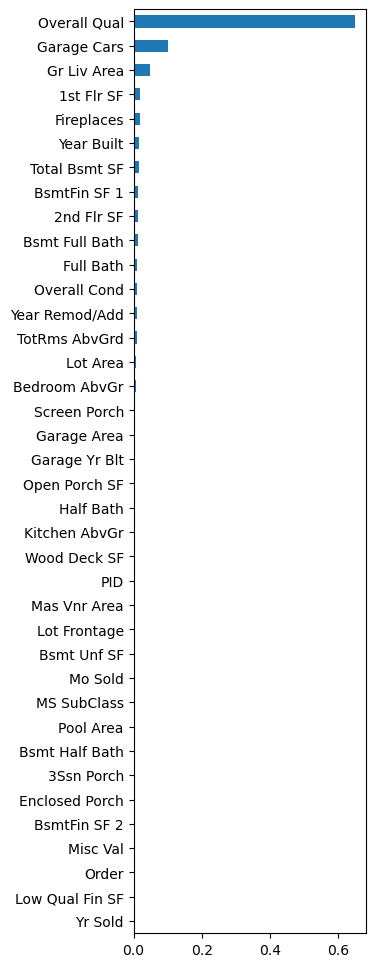

In [31]:
# Plot feature importances from the XGBoost model
(pd.Series(xg.feature_importances_, index=X_train.columns)  # Create a Series mapping feature names to their importance scores from the XGBoost model
 .sort_values()                                             # Sort the feature importances in ascending order for better visualization
 .plot.barh(figsize=(3, 12))                                # Plot the sorted feature importances as a horizontal bar chart with a specified figure size
);

It doesn't have a direction, it only has a size. So in this case, it is saying that the feature that impacted our model the most was the overall quality. After that, it was the garage cars. And at a high level what's going on here, you can think we have a bunch of trees. The features that are at the top of the trees where it makes those decisions tend to be the most important features. So this is basically a way of measuring which features come at the top of the trees. You can see that there are some of these features at the bottom that have very low scores, meaning that those features don't really impact or drive the model too much. 

In [33]:
# Use categories
# (Need to convert pyarrow numbers to pandas 1.x numbers)

# Convert pyarrow integers to pandas 1.x compatible 'Int64' type and drop 'SalePrice' from features
X_cat = (housing2.assign(**housing2.select_dtypes('number').astype('Int64'))  # Convert numeric columns to 'Int64' type for compatibility with XGBoost
         .drop(columns='SalePrice'))                                          # Drop the 'SalePrice' column from the features

y_cat = housing2['SalePrice']  # Set 'SalePrice' as the target variable

# Split the dataset into training and testing sets
X_cat_train, X_cat_test, y_cat_train, y_cat_test = model_selection.train_test_split(X_cat, y_cat, random_state=42)  

# Initialize the XGBoost regressor with categorical support and train it
xg_cat = xgb.XGBRegressor(enable_categorical=True, tree_method='hist')  # Initialize XGBoost with support for categorical features and 
                                                                        # use the 'hist' tree method for faster training

xg_cat.fit(X_cat_train, y_cat_train)           # Fit the model to the training data

# Evaluate the model on the test data
score = xg_cat.score(X_cat_test, y_cat_test)  # Calculate the R^2 score of the model on the test data
print(score)                                  # Output the R^2 score

0.9202194809913635


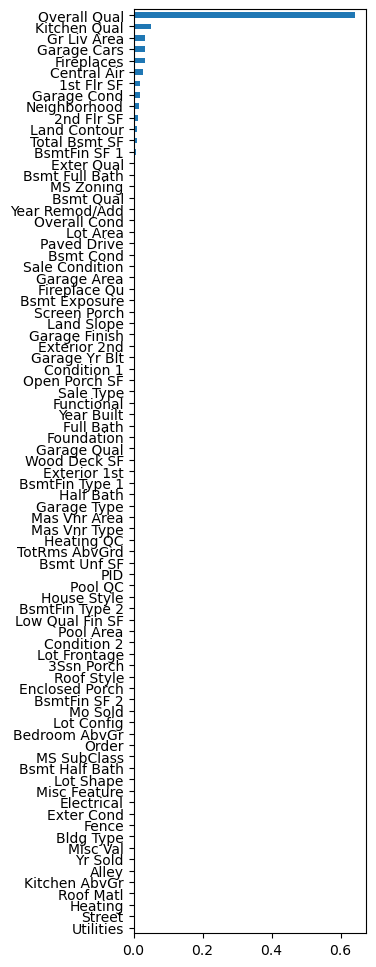

In [34]:
# Plot feature importances from the XGBoost model that supports categorical features
(pd.Series(xg_cat.feature_importances_, index=xg_cat.feature_names_in_) # Create a Series mapping feature names to their importance scores from the XGB
 .sort_values()                                                         # Sort the feature importances in ascending order for better visualization
 .plot.barh(figsize=(3, 12))                                            # Plot the sorted feature importances as a horizontal bar chart 
);

### 03_05 - Challenge: Predict Ames
* Create a linear regression model using the top 5 features from the (non-categorical) XGBoost model
* What is the `.score` of the model?

In [36]:
xg.feature_importances_

array([6.41042832e-04, 2.27620779e-03, 1.18792441e-03, 1.33234414e-03,
       7.12101953e-03, 6.48659289e-01, 1.12187853e-02, 1.46964146e-02,
       9.56929289e-03, 1.59942289e-03, 1.41326357e-02, 7.26479397e-04,
       1.30956247e-03, 1.44029809e-02, 1.86393056e-02, 1.35761686e-02,
       4.62268916e-04, 4.75824252e-02, 1.17736515e-02, 9.34704789e-04,
       1.12202708e-02, 3.27226170e-03, 6.30422495e-03, 2.78497091e-03,
       9.21827834e-03, 1.78232752e-02, 4.51962603e-03, 1.01024002e-01,
       4.72308137e-03, 2.53191055e-03, 4.46232222e-03, 8.80706357e-04,
       9.29115398e-04, 5.55692753e-03, 9.76907439e-04, 6.91475114e-04,
       1.23865402e-03, 0.00000000e+00], dtype=float32)

In [37]:
pd.Series(xg.feature_importances_, index=X_train.columns)

Order              0.000641
PID                0.002276
MS SubClass        0.001188
Lot Frontage       0.001332
Lot Area           0.007121
Overall Qual       0.648659
Overall Cond       0.011219
Year Built         0.014696
Year Remod/Add     0.009569
Mas Vnr Area       0.001599
BsmtFin SF 1       0.014133
BsmtFin SF 2       0.000726
Bsmt Unf SF        0.001310
Total Bsmt SF      0.014403
1st Flr SF         0.018639
2nd Flr SF         0.013576
Low Qual Fin SF    0.000462
Gr Liv Area        0.047582
Bsmt Full Bath     0.011774
Bsmt Half Bath     0.000935
Full Bath          0.011220
Half Bath          0.003272
Bedroom AbvGr      0.006304
Kitchen AbvGr      0.002785
TotRms AbvGrd      0.009218
Fireplaces         0.017823
Garage Yr Blt      0.004520
Garage Cars        0.101024
Garage Area        0.004723
Wood Deck SF       0.002532
Open Porch SF      0.004462
Enclosed Porch     0.000881
3Ssn Porch         0.000929
Screen Porch       0.005557
Pool Area          0.000977
Misc Val           0

In [38]:
(pd.Series(xg.feature_importances_, index=X_train.columns) 
 .sort_values(ascending=False))

Overall Qual       0.648659
Garage Cars        0.101024
Gr Liv Area        0.047582
1st Flr SF         0.018639
Fireplaces         0.017823
Year Built         0.014696
Total Bsmt SF      0.014403
BsmtFin SF 1       0.014133
2nd Flr SF         0.013576
Bsmt Full Bath     0.011774
Full Bath          0.011220
Overall Cond       0.011219
Year Remod/Add     0.009569
TotRms AbvGrd      0.009218
Lot Area           0.007121
Bedroom AbvGr      0.006304
Screen Porch       0.005557
Garage Area        0.004723
Garage Yr Blt      0.004520
Open Porch SF      0.004462
Half Bath          0.003272
Kitchen AbvGr      0.002785
Wood Deck SF       0.002532
PID                0.002276
Mas Vnr Area       0.001599
Lot Frontage       0.001332
Bsmt Unf SF        0.001310
Mo Sold            0.001239
MS SubClass        0.001188
Pool Area          0.000977
Bsmt Half Bath     0.000935
3Ssn Porch         0.000929
Enclosed Porch     0.000881
BsmtFin SF 2       0.000726
Misc Val           0.000691
Order              0

<Axes: >

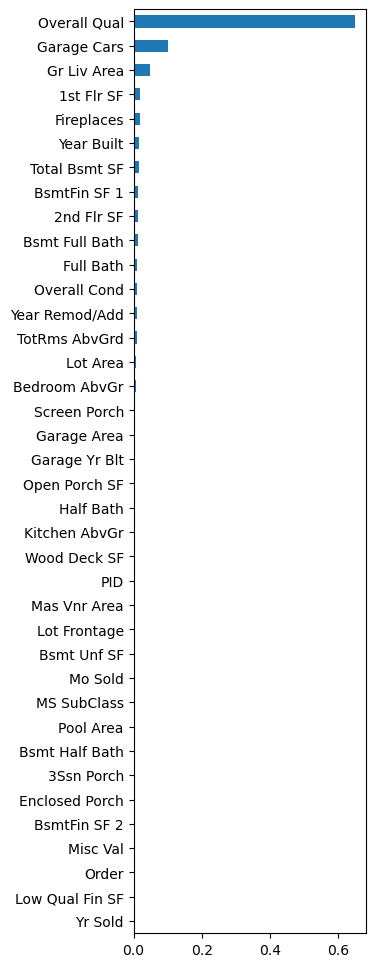

In [39]:
# Sort feature importances in descending order and plot as a horizontal bar chart
(pd.Series(xg.feature_importances_, index=X_train.columns)  # Create a Series mapping feature names to their importance scores
 .sort_values(ascending=True)                               # Sort the feature importances in descending order (high to low)
 .plot.barh(figsize=(3, 12))                                # Plot the sorted feature importances as a horizontal bar chart with the specified size
)

In [40]:
(pd.Series(xg.feature_importances_, index=X_train.columns) 
 .sort_values(ascending=True)
 .index[-5:]
)

Index(['Fireplaces', '1st Flr SF', 'Gr Liv Area', 'Garage Cars',
       'Overall Qual'],
      dtype='object')

In [41]:
top5 = list(pd.Series(xg.feature_importances_, index=X_train.columns) 
 .sort_values(ascending=True)
 .index[-5:]
)

top5

['Fireplaces', '1st Flr SF', 'Gr Liv Area', 'Garage Cars', 'Overall Qual']

In [42]:
# Train a linear regression model using only the top 5 most important features

lr_top5 = linear_model.LinearRegression()   # Initialize the linear regression model

# Fit the linear regression model to the training data using only the top 5 features
lr_top5.fit(X_train.loc[:, top5], y_train)  # Use .loc to select the top 5 features from X_train

# Evaluate the model using the test data, restricted to the top 5 features
lr_top5_score = lr_top5.score(X_test.loc[:, top5], y_test)  # Use .loc to select the same top 5 features from X_test

print(lr_top5_score)  # Output the R^2 score of the model

0.7949314168664728
